# Remaining Life Prediction for Turbofan Engine - Regression

## Data Exploration

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from turbofan_importFDdata import turbofan_importFDdata

**Loading the dataset FD002**

In [30]:
data = turbofan_importFDdata('train_FD002.txt')
data

,Unit,Time,Setting1,Setting2,Setting3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729


**Overview on all sensor measurments for all units**

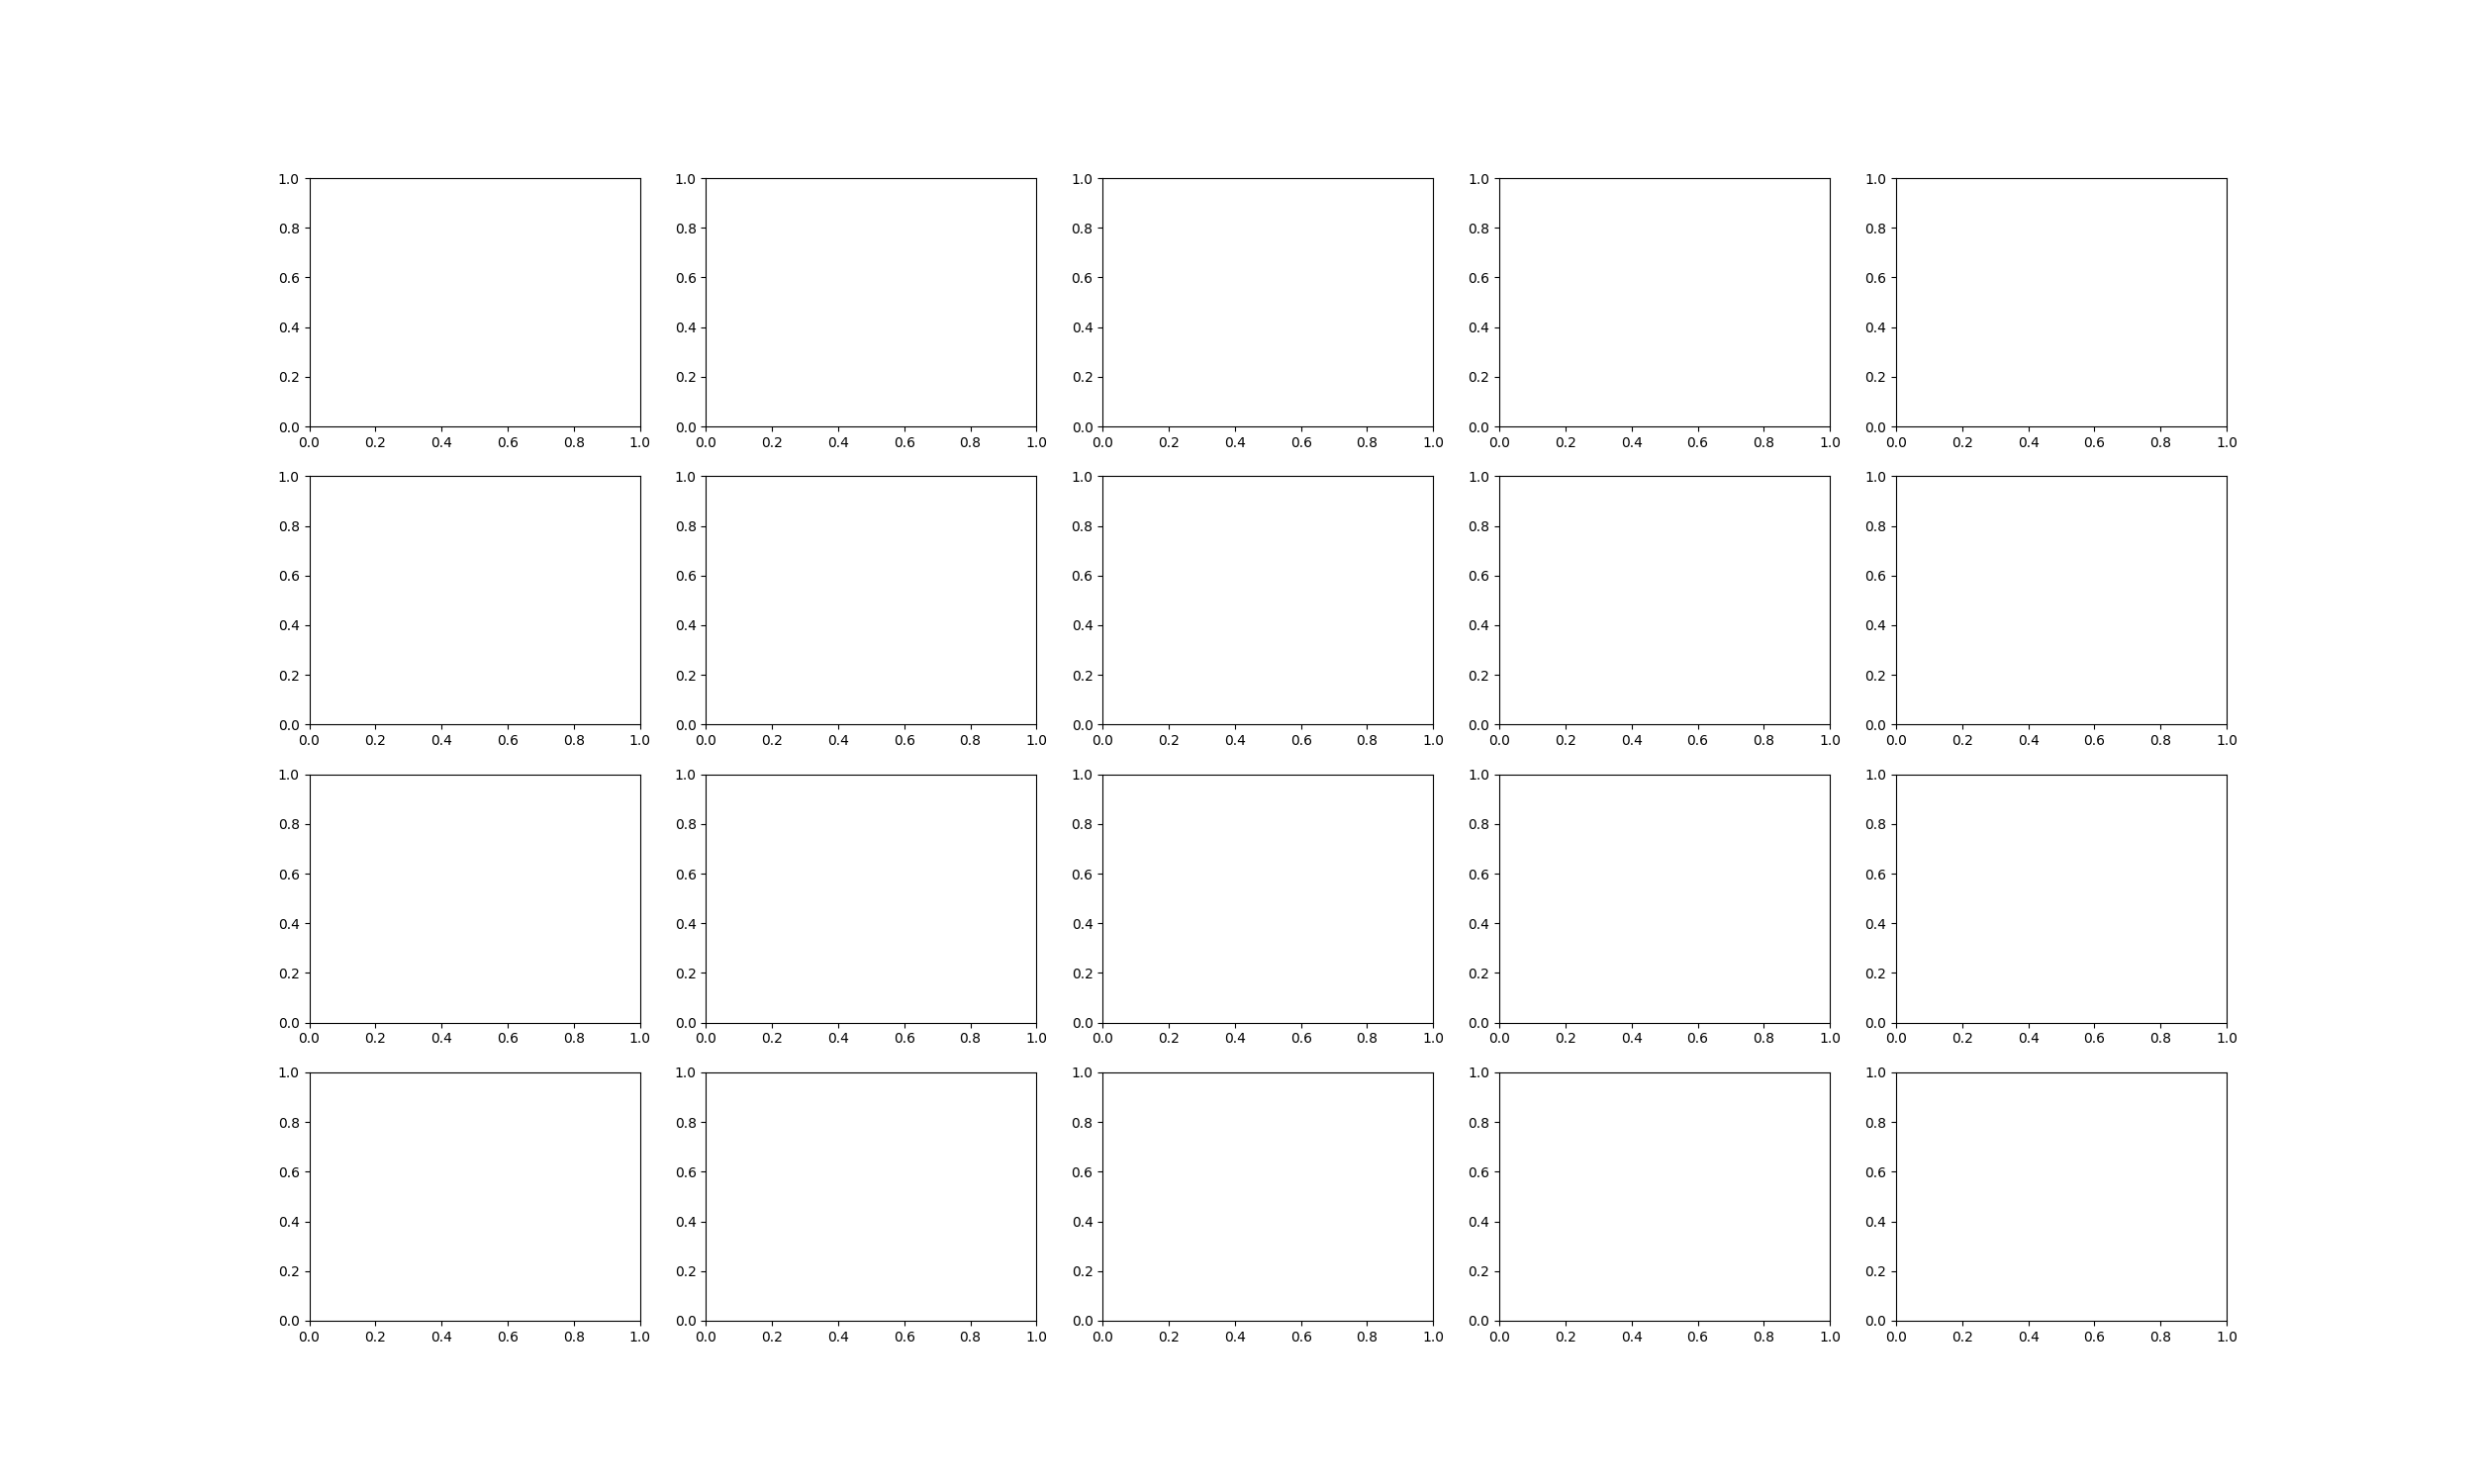

In [31]:
fig, axs = plt.subplots(4, 5)
fig.set_figheight(15)
fig.set_figwidth(25)

# iterate over units

#for u in range(260): 
#    # iterate over sensor measurments
#    for s in range(5):
#        axs[0,s].scatter(data.loc[data.Unit==u+1, 'Time'], data.loc[data.Unit==u+1, data.columns[s+5]])
#        axs[0,s].set_title(data.columns[s+5])
#    for s in range(5): 
#        axs[1,s].scatter(data.loc[data.Unit==u+1, 'Time'], data.loc[data.Unit==u+1, data.columns[s+10]])
#        axs[1,s].set_title(data.columns[s+10])
#    for s in range(5):
#        axs[2,s].scatter(data.loc[data.Unit==u+1, 'Time'], data.loc[data.Unit==u+1, data.columns[s+15]])
#        axs[2,s].set_title(data.columns[s+15])
#    for s in range(5):
#        axs[3,s].scatter(data.loc[data.Unit==u+1, 'Time'], data.loc[data.Unit==u+1, data.columns[s+20]])
#        axs[3,s].set_title(data.columns[s+20])

**Determining the operation mode from the operational Settings**  
We can compute and round the average of the three settings to determine the different operation modes:

In [32]:
modi = np.round((data.loc[:,'Setting1'] + data.loc[:,'Setting2'] + data.loc[:,'Setting3']) /3)
print(f'Unique modes: {modi.unique()}')

Unique modes: [45. 48. 29. 40. 33. 37.]


We can also view that by clustering the settings:

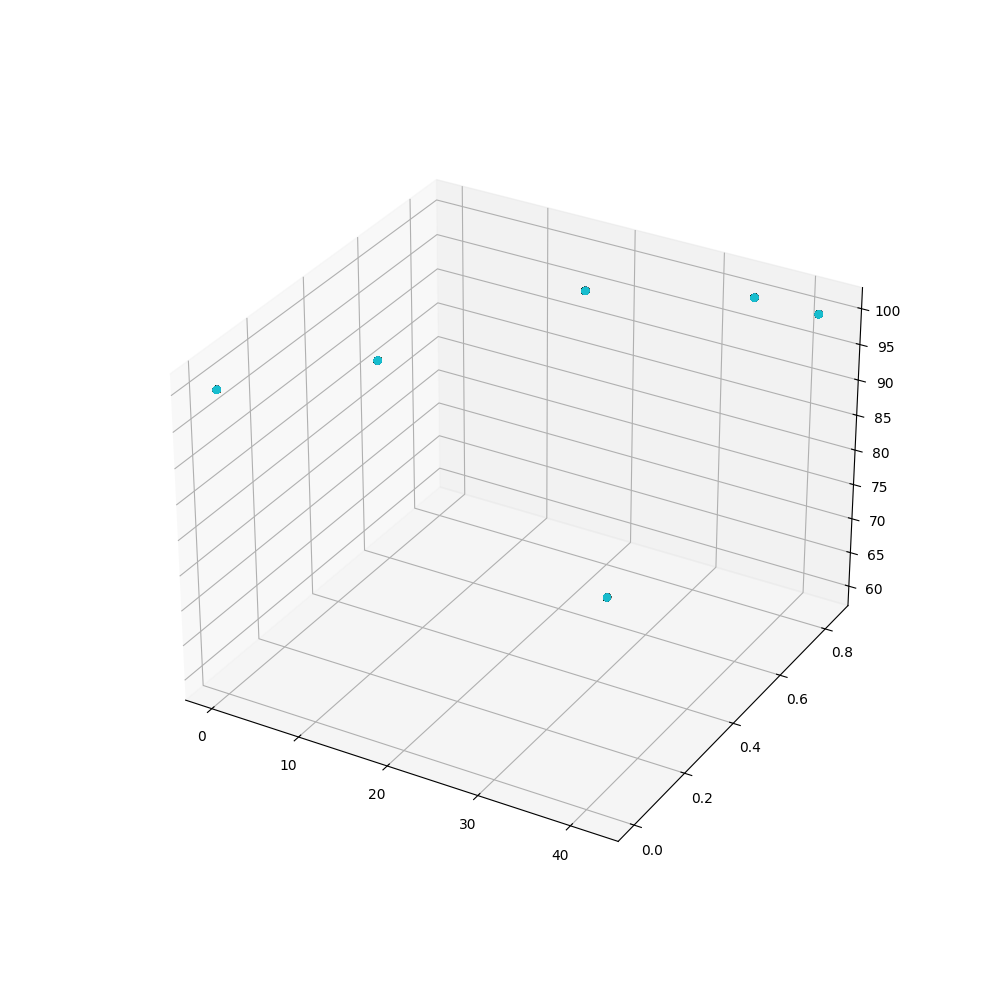

In [33]:
data_per_engine = data.groupby('Unit')
data_per_engine = [data_per_engine.get_group(x) for x in data_per_engine.groups]

fig = plt.figure(figsize=(10, 10))
#add 3d scatter plot
ax = fig.add_subplot(111, projection='3d')
for i, engine_data in enumerate(data_per_engine):
    ax.scatter(engine_data['Setting1'], engine_data['Setting2'], engine_data['Setting3'])

We now add a column containing the operation mode:

In [34]:
data.drop('Setting1', inplace=True, axis=1)
data.drop('Setting2', inplace=True, axis=1)
data.drop('Setting3', inplace=True, axis=1)
data.insert(2, 'Modi', modi)
data.loc[data.Modi == 29, 'Modi'] = 1
data.loc[data.Modi == 33, 'Modi'] = 2
data.loc[data.Modi == 37, 'Modi'] = 3
data.loc[data.Modi == 40, 'Modi'] = 4
data.loc[data.Modi == 45, 'Modi'] = 5
data.loc[data.Modi == 48, 'Modi'] = 6

In [35]:
data

,Unit,Time,Modi,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,BypassDuctPres,TotalHPCOutletPres,...,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,5.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,6.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,1.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,6.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,1.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,4.0,491.19,608.79,1495.60,1269.51,9.35,13.66,334.00,...,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189
53755,260,313,3.0,489.05,605.81,1514.32,1324.12,10.52,15.50,392.46,...,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454
53756,260,314,1.0,462.54,537.48,1276.24,1057.92,7.05,9.04,175.11,...,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503
53757,260,315,1.0,462.54,537.84,1272.95,1066.30,7.05,9.04,174.81,...,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729


## Data Preparation
**Shift the time variable to a count down timer for remaining cycles to failure**

In [36]:
for i in range(1,261):
    data.loc[data.Unit == i] = data.loc[data.Unit == i].assign(Time=data.loc[data.Unit == i].loc[:,"Time"].max()-data.loc[data.Unit == i].loc[:,"Time"])

**Data Standardization**

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = pd.concat([data.iloc[:,0:3], pd.DataFrame(scaler.fit_transform(data.iloc[:,3:]))], axis=1)

**Add labels to the instances of the training set reflecting urgency indicators**

In [38]:
data = data.assign(Urgency = pd.cut(data['Time'], bins=[-1, 51, 126, 201, 1000], labels=['Urg', 'Short', 'Med', 'Long']))
data

,Unit,Time,Modi,0,1,2,3,4,5,6,...,12,13,14,15,16,17,18,19,20,Urgency
0,1,148,5.0,-0.889378,-0.653071,-0.579176,-0.572622,-0.706177,-0.662907,-0.602496,...,0.415116,-0.212615,0.021948,-0.705933,-0.515579,-0.039954,0.418187,-0.613958,-0.619148,Med
1,1,147,6.0,-1.057627,-0.798422,-0.630051,-0.668741,-1.140622,-1.084502,-0.986938,...,0.414648,0.067215,0.063719,-0.705933,-0.659701,-0.115645,0.418187,-1.051681,-1.048190,Med
2,1,146,1.0,-0.392968,-1.136055,-1.540521,-1.326301,-0.271732,-0.475122,-0.732150,...,-2.393490,-2.377822,2.087798,-0.705933,-1.416342,-2.159318,-2.391275,-0.679819,-0.641912,Med
3,1,145,6.0,-1.057627,-0.808881,-0.622406,-0.663705,-1.140622,-1.084502,-0.987280,...,0.414257,0.024309,0.030890,-0.705933,-0.695731,-0.115645,0.418187,-1.033443,-1.013808,Med
4,1,144,1.0,-0.392968,-1.142491,-1.531554,-1.322271,-0.271732,-0.473281,-0.736670,...,-2.393724,-2.420728,2.090734,-0.705933,-1.416342,-2.159318,-2.391275,-0.674753,-0.666180,Med
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,4,4.0,0.692693,0.780862,0.713849,0.537834,0.364716,0.379114,0.351999,...,0.425267,1.214589,-0.034903,1.416565,0.745489,0.655032,0.418187,0.361801,0.345429,Urg
53755,260,3,3.0,0.611600,0.700946,0.890544,0.996270,0.688475,0.717863,0.752399,...,0.420582,2.107123,-0.762087,1.416565,0.925641,0.620627,0.418187,0.740757,0.755203,Urg
53756,260,2,1.0,-0.392968,-1.131496,-1.356652,-1.238408,-0.271732,-0.471440,-0.736259,...,-2.375530,-1.123891,2.316803,-0.705933,-1.380311,-2.159318,-2.391275,-0.668673,-0.662515,Urg
53757,260,1,1.0,-0.392968,-1.121841,-1.387706,-1.168060,-0.271732,-0.471440,-0.738314,...,-2.375374,-1.109510,2.300789,-0.705933,-1.344281,-2.159318,-2.391275,-0.682859,-0.692473,Urg


## Modeling & Training

**PCA**

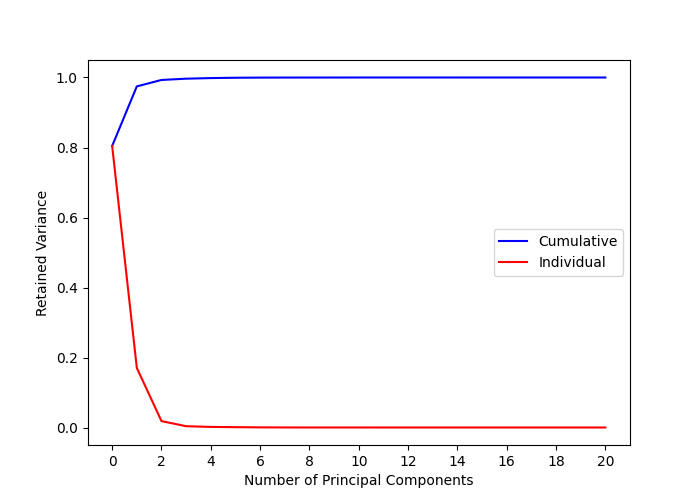

In [39]:
# PCA
Z = data.values[:, 3:-1]
pca = PCA().fit(Z)
coeff = (pca.components_).T
score = pca.transform(Z)
variance_ratio = pca.explained_variance_ratio_

fig = plt.figure(figsize=(7, 5))

n = data.shape[1] -4

# >>> enter your code here
plt.plot(range(n), variance_ratio.cumsum(), 'b-')
plt.plot(range(n), variance_ratio, 'r-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Retained Variance')
plt.xticks(range(0, 21, 2))
plt.legend(['Cumulative', 'Individual']);

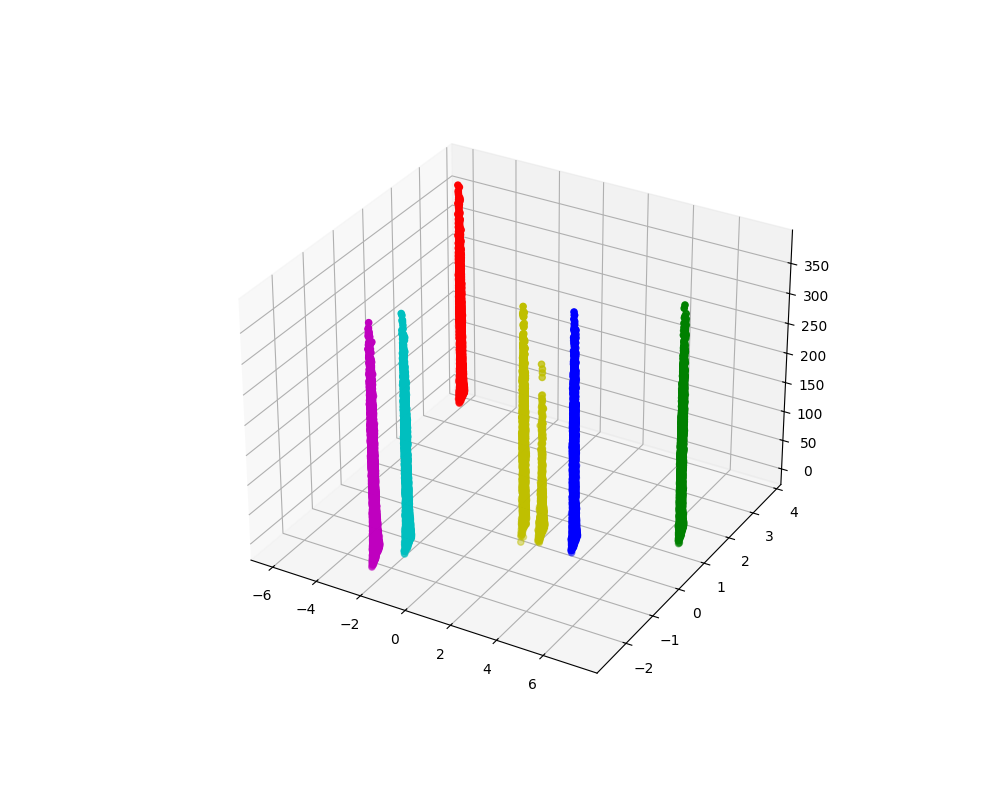

In [40]:
%matplotlib ipympl
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
n = len(modi+1)
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i, c in enumerate(colors):
    idx = np.argwhere(data['Modi'] == i+1).squeeze()
    ax.scatter(score[idx, 0], score[idx, 1], data['Time'][idx], c=c)
#unit = np.argwhere(data.values[:, 0] == 10).squeeze()
#idx = np.argwhere(data.values[:, 2] == 1.0).squeeze()
#ax.scatter(score[idx, 0], score[idx, 1], data['Time'][idx], color='r')
#idx = np.argwhere(data.values[:, 2] == 2.0).squeeze()
#ax.scatter(score[idx, 0], score[idx, 1], data['Time'][idx], color='b')
# idx = np.argwhere(data.values[:, 2] == 3.0).squeeze()
# ax.scatter(score[unit, 0], score[unit, 1], data['Time'][unit], color='g')

Get amount of observations per mode

In [41]:
for i in range(1, 7):
    print(f'Mode {i}: {len(np.argwhere(data["Modi"] == i).squeeze())} observations')
    

Mode 1: 8002 observations
Mode 2: 8044 observations
Mode 3: 8096 observations
Mode 4: 8122 observations
Mode 5: 8037 observations
Mode 6: 13458 observations


Make PCA for mode 6

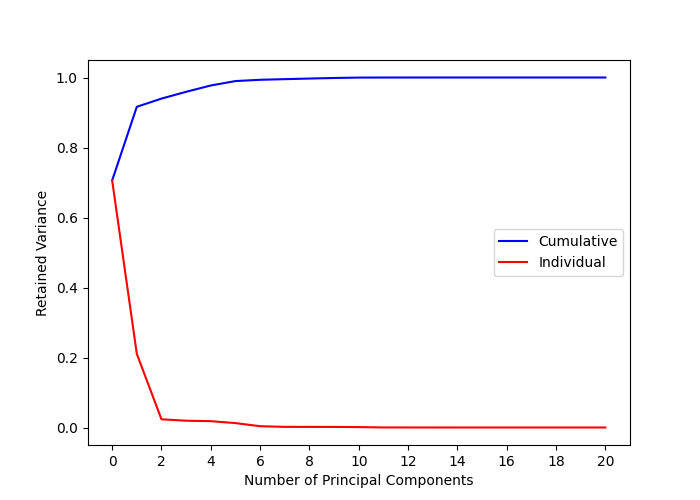

In [42]:
data_mode_six = data[data['Modi'] == 6]
Z = data_mode_six.values[:, 3:-1]
pca_mode_six = PCA().fit(Z)
coeff = (pca_mode_six.components_).T
score = pca_mode_six.transform(Z)
variance_ratio = pca_mode_six.explained_variance_ratio_

fig = plt.figure(figsize=(7, 5))

n = data.shape[1] -4

# >>> enter your code here
plt.plot(range(n), variance_ratio.cumsum(), 'b-')
plt.plot(range(n), variance_ratio, 'r-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Retained Variance')
plt.xticks(range(0, 21, 2))
plt.legend(['Cumulative', 'Individual']);

Text(0.5, 0, 'Time')

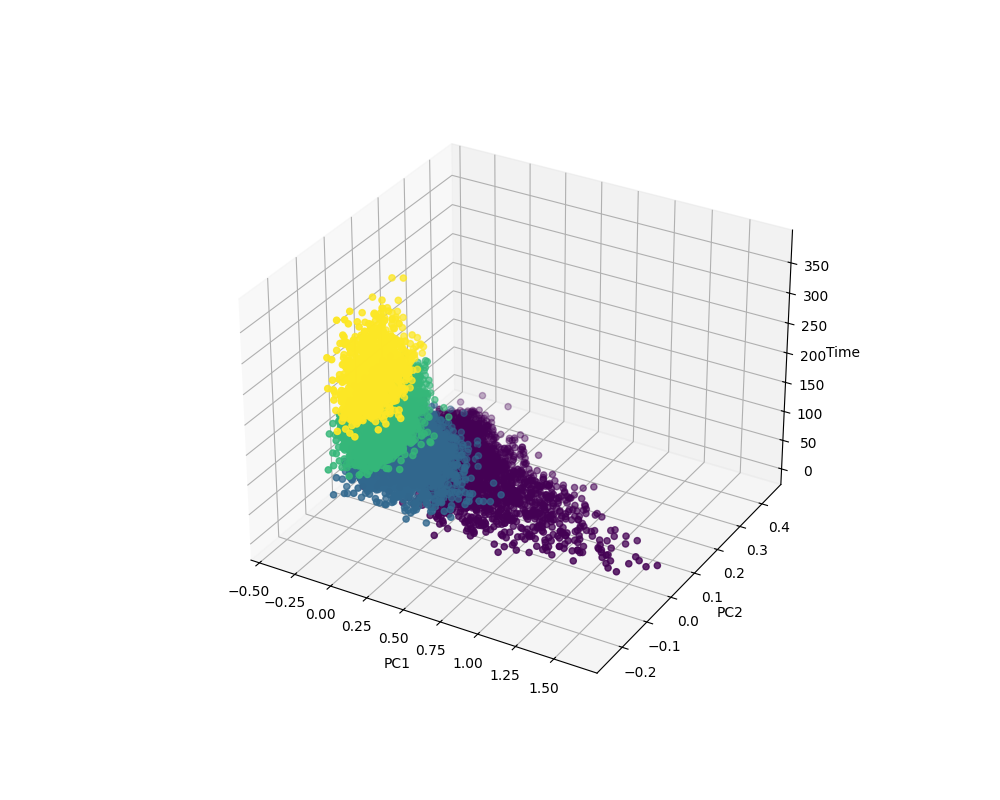

In [43]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
# Plot the data with color of point dependant on value of "Urgency"
ax.scatter(score[:, 0], score[:, 1], data_mode_six['Time'], c=data_mode_six['Urgency'].cat.codes, cmap='viridis')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Time')

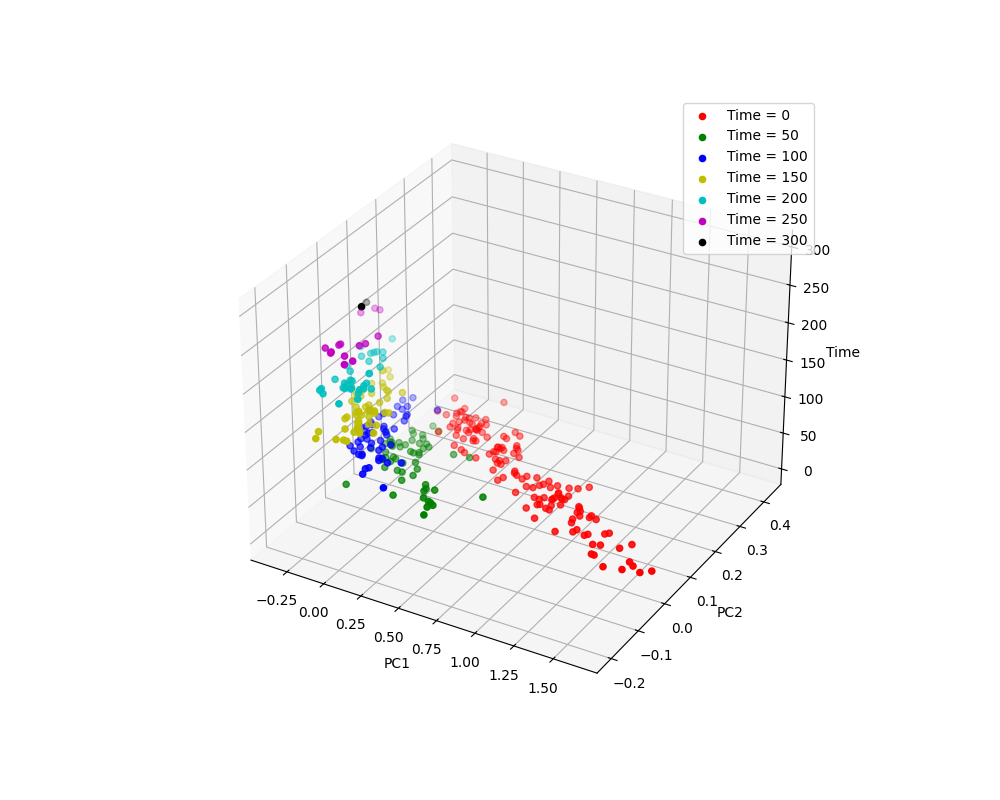

In [44]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

#ax.scatter(score[:, 0], score[:, 1], data_mode_six['Time'][:], c=c, alpha=0.3)
times = [0, 50, 100, 150, 200, 250, 300]
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
# Add a scatter for when Time is 0
for i, t in enumerate(times):
    idx = np.argwhere(data_mode_six['Time'] == t).squeeze()
    ax.scatter(score[idx, 0], score[idx, 1], t, c=colors[i], label=f'Time = {t}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Time')
ax.legend()

In [45]:
# Find line of best fit for Time = 0
from sklearn.linear_model import LinearRegression
x = score[np.argwhere(data_mode_six['Time'] == 0).squeeze(), 0]
y = score[np.argwhere(data_mode_six['Time'] == 0).squeeze(), 1]
reg = LinearRegression().fit(x.reshape(-1, 1), y)
print(f'Line of best fit for Time = 0: y = {reg.coef_[0]}x + {reg.intercept_}')

Line of best fit for Time = 0: y = -0.1750380185463704x + 0.29591873599820123


Find good combination of PC1 and PC2

Text(0, 0.5, 'Time')

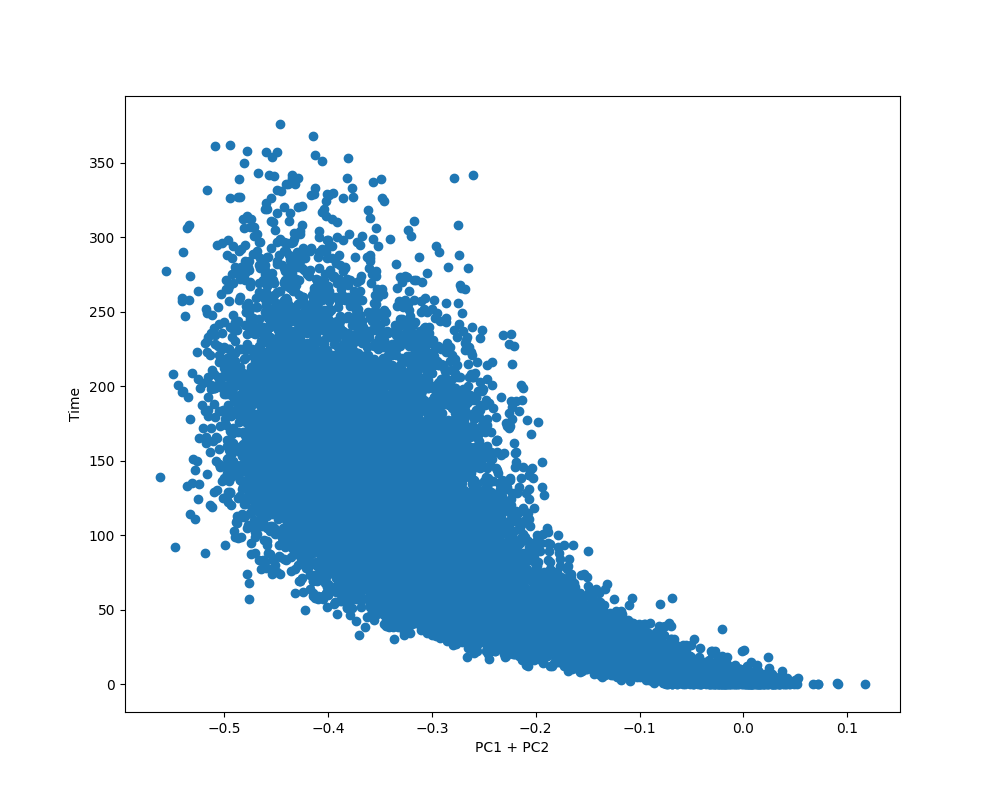

In [46]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.plot(score[:, 0]*0.18+score[:, 1] - 0.3, data_mode_six['Time'][:], "o")
ax.set_xlabel('PC1 + PC2')
ax.set_ylabel('Time')

Nonlinear regression


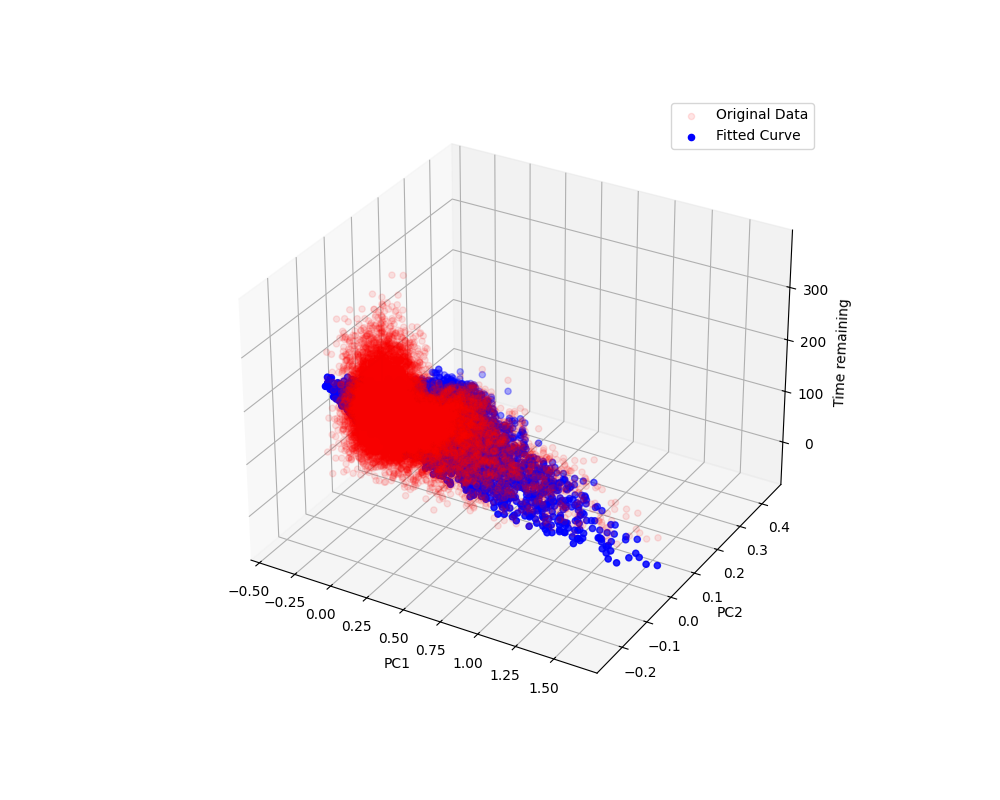

In [47]:
# Run a polynomial regression with PC1 and PC2 as predictors, and Time as the response with regularization
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the exponential function
def exponential_func(pcs, a, b, c, d):
    return (a*np.exp(b * pcs[:, 0] + c*pcs[:, 1]) + d).flatten()

x_data = score[:, 0:2].reshape(-1, 2)
y_data = data_mode_six['Time'][:].to_numpy()
# Fit the curve using curve_fit
params, covariance = curve_fit(exponential_func, x_data, y_data)#, maxfev=int(1e6))

# Extract the optimized parameters
a_opt, b_opt, c_opt, d_opt = params

# Generate predicted y values using the fitted parameters
y_pred = exponential_func(x_data, a_opt, b_opt, c_opt, d_opt)

x1_grid = np.linspace(min(x_data[:, 0]), max(x_data[:, 0]), 100)
x2_grid = np.linspace(min(x_data[:, 1]), max(x_data[:, 1]), 100)
y_pred_grid = exponential_func(np.array(np.meshgrid(x1_grid, x2_grid, indexing="ij")).reshape(-1, 2), a_opt, b_opt, c_opt, d_opt).reshape(100, 100)

%matplotlib ipympl
# Plot the original data and the fitted curve
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_data[:, 0], x_data[:, 1], y_data, c='r', alpha=0.1, label='Original Data')
#plot surface of predicted values
#ax.plot_surface(x1_grid, x2_grid, y_pred_grid, label='Fitted Curve', color='b')
ax.scatter(x_data[:, 0], x_data[:, 1], y_pred, c='b', label='Fitted Curve')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Time remaining')
ax.legend()
plt.show()









## Testing

In [48]:
test_data = turbofan_importFDdata('test_FD002.txt')
rul = np.loadtxt('RUL_FD002.txt', dtype=int)
print(rul[:10])
test_data


[ 18  79 106 110  15 155   6  90  11  79]


,Unit,Time,Setting1,Setting2,Setting3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,35.0015,0.8403,100.0,449.44,555.56,1366.01,1129.47,5.48,...,183.05,2388.39,8088.36,9.3215,0.02,334,2223,100.00,14.94,8.9065
33987,259,120,42.0066,0.8405,100.0,445.00,549.42,1351.13,1123.86,3.91,...,130.74,2388.31,8108.48,9.3542,0.02,332,2212,100.00,10.57,6.4075
33988,259,121,42.0061,0.8400,100.0,445.00,549.65,1349.14,1118.91,3.91,...,130.96,2388.34,8098.77,9.3836,0.02,331,2212,100.00,10.57,6.4805
33989,259,122,0.0024,0.0003,100.0,518.67,642.58,1589.61,1408.16,14.62,...,522.25,2388.00,8161.85,8.4279,0.03,393,2388,100.00,39.08,23.3589


In [49]:
test_data.drop('Setting1', inplace=True, axis=1)
test_data.drop('Setting2', inplace=True, axis=1)
test_data.drop('Setting3', inplace=True, axis=1)
test_data.insert(2, 'Modi', modi)
test_data.loc[test_data.Modi == 29, 'Modi'] = 1
test_data.loc[test_data.Modi == 33, 'Modi'] = 2
test_data.loc[test_data.Modi == 37, 'Modi'] = 3
test_data.loc[test_data.Modi == 40, 'Modi'] = 4
test_data.loc[test_data.Modi == 45, 'Modi'] = 5
test_data.loc[test_data.Modi == 48, 'Modi'] = 6

In [50]:
#scale data with the same scaler as the training data
test_data = pd.concat([test_data.iloc[:,0:3], pd.DataFrame(scaler.transform(test_data.iloc[:,3:]))], axis=1)

Text(0.5, 0, 'Time')

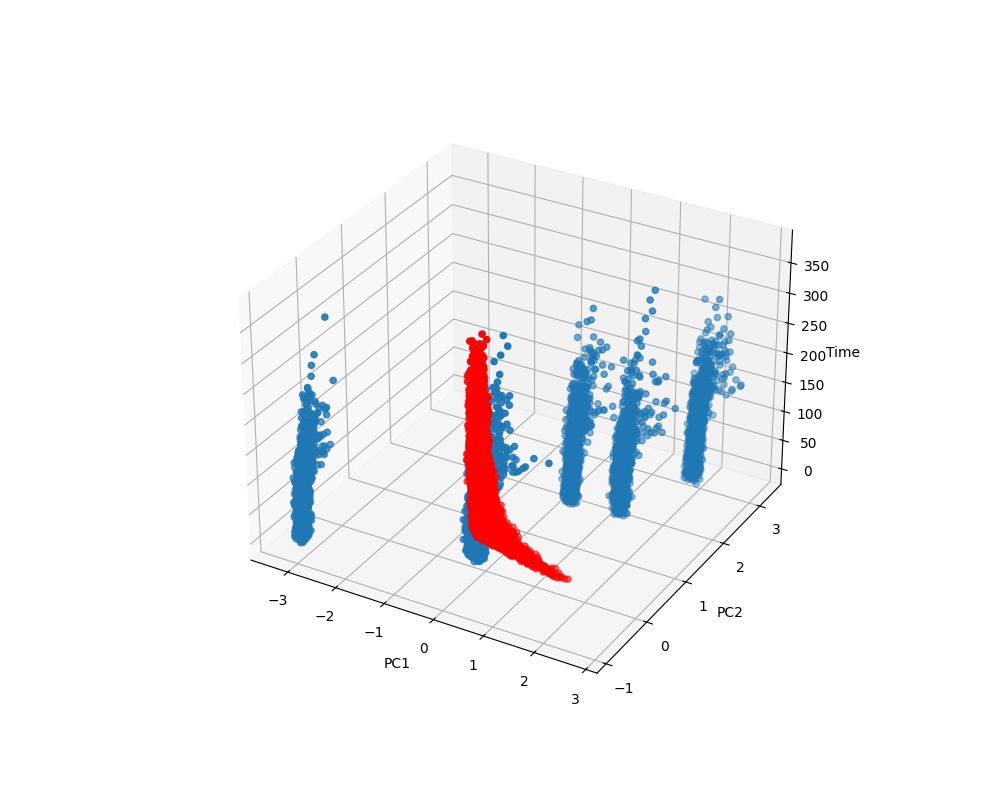

In [54]:
test_data_mode_six = test_data[test_data['Modi'] == 6]
Z_test = test_data_mode_six.values[:, 3:]
test_score = pca_mode_six.transform(Z_test)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
# Plot the data with color of point dependant on value of "Urgency"
ax.scatter(test_score[:, 0], test_score[:, 1], test_data_mode_six['Time'])
ax.scatter(score[:, 0], score[:, 1], data_mode_six['Time'], c='r')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Time')



Text(0, 0.5, 'Difference between predicted and true RUL')

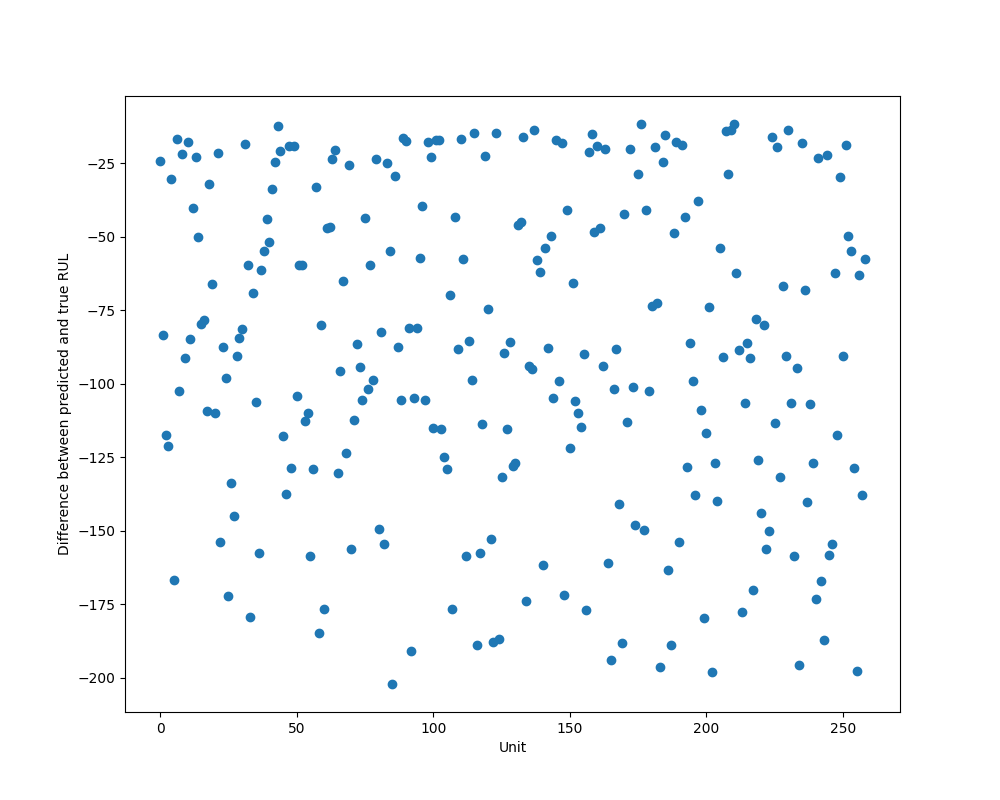

In [52]:
#For each Unit, get all observations with Modi = 6
all_observations = test_data_mode_six.groupby('Unit')
last_observations = test_data_mode_six.groupby('Unit').last()   
cycles_pred = []
unit_preds = []
for unit in all_observations:
    for i, row in unit[1].iterrows():
        test_score = pca_mode_six.transform(row.values[3:].reshape(1, -1))
        pred = exponential_func(test_score[0, 0:2].reshape(1, -1), a_opt, b_opt, c_opt, d_opt)
        if abs(pred) > 1000:
            continue
        unit_preds.append(float(pred))
    mean_pred = np.mean(unit_preds)
    cycles_pred.append(mean_pred)
    if abs(mean_pred) > 1000:
        print(f'Unit {unit[0]}: {unit_preds}')

#for i, truth in enumerate(rul):
#    print(f"Pred: {cycles_pred[i]} RUL: {truth}")

# plot the difference between predicted and true RUL
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
ax.plot([i for i in range(len(cycles_pred))], cycles_pred-rul, "o")
ax.set_xlabel('Unit')
ax.set_ylabel('Difference between predicted and true RUL')
#ax.set_yscale('log')
